## PhoREAL / SlideRule Example

Demonstrate running the PhoREAL algorithm in SlideRule to produce canopy metrics over the Grand Mesa, Colorado region.

#### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import geopandas
import logging
import sliderule
from sliderule import icesat2

#### Initialize Client
* Organization currently set to "utexas"; if you want to be a member of the utexas SlideRule organization, make a request through the SlideRule provisioning system (https://ps.slideruleearth.io); otherwise, remove the organization parameter to default to the public SlideRule cluster.
* Notebook only processes one granule, so one desired_node is sufficient

In [3]:
icesat2.init("slideruleearth.io", verbose=True, loglevel=logging.INFO)

Setting URL to slideruleearth.io
Client (version (4, 9, 4)) is out of date with the server (version (4, 11, 1))


#### Processing parameters
* 100m segments stepped every 100m
* Subsetted to the Grand Mesa region
* Time range is one day, Nov 14, 2019
* Only processing ground, canopy, and top of canopy photons
* Request the "h_dif_ref" variable as an ancillary field to be included in the results
* Running PhoREAL algorithm using a binsize of 1m, and geolocating each segment at the center of the segment
* Sending reconstructed waveforms along with metrics (for diagnostics and demonstration purposes only)

In [4]:
# Specify region of interest from geojson
poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84_simple.geojson'
# poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/grandmesa.geojson'
region = sliderule.toregion(poly_fn)["poly"] # symplify 
region

parms = { #Reynolds Creek Experimental Watershed
    "poly": region, # polygon defining region of interest 
    # "raster": raster, # geojson describing region of interest which enables rasterized subsetting on servers
    "t0": '2018-11-26T00:00:00Z', # start time for filtering granules (format %Y-%m-%dT%H:%M:%SZ, e.g. 2018-10-13T00:00:00Z)
    "t1": '2018-11-27T00:00:00Z', # stop time for filtering granuels (format %Y-%m-%dT%H:%M:%SZ, e.g. 2018-10-13T00:00:00Z)
    "srt": icesat2.SRT_LAND, # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "len": 100, # length of each extent in meters. If res is less than len, subsequent segments will contain duplicate photons.
    "res": 100, # step distance for successive extents in meters. Specifies the distance between subsequent extent centers.
    "dist_in_seg": False, # true|false flag indicating that the units of the "len" and "res" are in ATL03 segments (e.g. if true then a len=2 is exactly 2 ATL03 segments which is approximately 40 meters)
    "pass_invalid": True, # true|false flag indicating whether or not extents that fail validation checks are still used and returned in the results
    "atl03_ph_fields": ["pce_mframe_cnt"], # fields in the “heights” group of the ATL03 granule
    "atl03_geo_fields": ["solar_elevation"], # fields in the “geolocation” and “geophys_corr” groups of the ATL03 granule
    "atl08_class": ["atl08_ground", "atl08_canopy", "atl08_top_of_canopy"], # ATL08 photon classifications. The classifications are: “atl08_noise”, “atl08_ground”, “atl08_canopy”, “atl08_top_of_canopy”, “atl08_unclassified”)
    "atl08_fields": ["h_dif_ref"], # fields in the “land_segments” group of the ATL08 granule
    "phoreal": {"binsize": 1.0, "geoloc": "center", "use_abs_h": False, "send_waveform": True}
}


ERROR 1: PROJ: proj_create_from_database: Open of /bsuhome/tnde/miniconda3/envs/lidar/share/proj failed


#### Make Atl08 Request

In [5]:
# sliderule.toregion('shapefiles/grandmesa.geojson')['poly']
# region

In [6]:
atl08 = icesat2.atl08p(parms, keep_id=True)

request <AppServer.51131> retrieved 1 resources from CMR
Starting proxy for atl08 to process 1 resource(s) with 1 thread(s)
request <AppServer.51634> processing initialized on ATL03_20181126210453_09050102_006_02.h5 ...
Successfully completed processing resource [1 out of 1]: ATL03_20181126210453_09050102_006_02.h5


#### Print Resulting GeoDataFrame

In [7]:
atl08#["h_mean_canopy"]

,snowcover,gt,canopy_openness,gnd_ph_count,rgt,x_atc,h_mean_canopy,h_canopy,h_max_canopy,ph_count,...,solar_elevation_x,h_te_median,extent_id,geometry,waveform,num_bins,binsize,pce_mframe_cnt,solar_elevation_y,h_dif_ref
time,,,,,,,,,,,,,,,,,,,,,
2018-11-26 21:09:05.590024960,2,10,0.282533,0,905,4804119.5,5.501058,5.941040,5.941040,6,...,22.218178,0.000000,4075757741153452034,POINT (-116.69179 43.16377),[1.0],1,1.0,277331720,22.217695,-3.892578
2018-11-26 21:09:05.600325120,2,10,11.117661,1,905,4804193.0,13.568094,48.431396,48.431396,36,...,22.217569,1564.271729,4075757741153452038,POINT (-116.69188 43.16443),"[0.02777777798473835, 0.02777777798473835, 0.0...",47,1.0,277331721,22.216734,-3.892578
2018-11-26 21:09:05.668974848,2,10,NaN,1,905,4804681.0,NaN,0.000000,0.000000,1,...,22.213369,1415.212646,4075757741153452058,POINT (-116.69246 43.1688),[0.0],1,1.0,277331724,22.213209,-3.892578
2018-11-26 21:09:05.730274816,2,10,NaN,1,905,4805116.5,NaN,0.000000,0.000000,1,...,22.210163,1354.815308,4075757741153452074,POINT (-116.69296 43.1727),[0.0],1,1.0,277331727,22.209679,-3.892578
2018-11-26 21:09:05.741675008,1,10,8.054248,0,905,4805197.0,22.436945,45.274536,45.274536,22,...,22.209366,0.000000,4075757741153452078,POINT (-116.69306 43.17342),"[0.04545454680919647, 0.0, 0.0, 0.0, 0.0454545...",40,1.0,277331727,22.209208,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26 21:09:07.330475008,1,20,1.469470,60,905,4814078.5,2.588119,6.997803,6.997803,91,...,22.137568,1303.513916,4075757741153452411,POINT (-116.70256 43.25307),"[0.09890110045671463, 0.08791209012269974, 0.0...",7,1.0,277331807,22.136919,1.510986
2018-11-26 21:09:07.344025088,1,20,3.836523,14,905,4814174.5,5.592039,12.500610,13.663330,109,...,22.136766,1324.233643,4075757741153452415,POINT (-116.70267 43.25393),"[0.19266055524349213, 0.10091742873191833, 0.0...",14,1.0,277331808,22.136450,-1.180420
2018-11-26 21:09:07.357975040,1,20,2.982843,8,905,4814273.5,6.160005,11.000000,12.374023,115,...,22.135962,1326.386963,4075757741153452419,POINT (-116.70279 43.25482),"[0.06086956337094307, 0.09565217047929764, 0.0...",12,1.0,277331808,22.135962,-1.070068


#### Plot Canopy Height

<Axes: xlabel='x_atc', ylabel='h_canopy'>

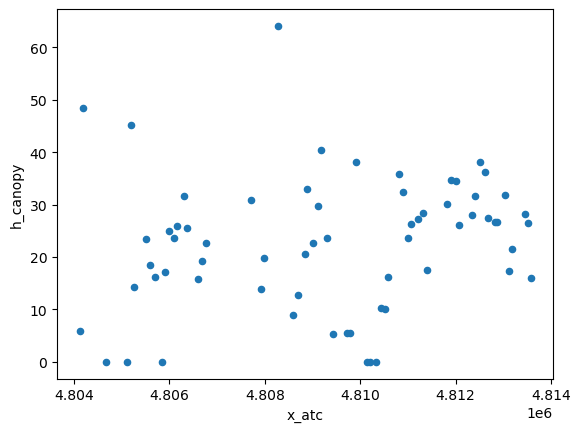

In [8]:
canopy_gt1l = atl08[atl08['gt'] == icesat2.GT1L]
canopy_gt1l.plot.scatter(x='x_atc', y='h_canopy')

#### Plot Landcover

<Axes: >

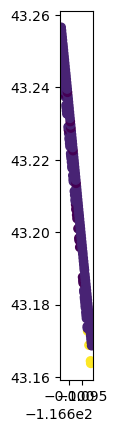

In [9]:
atl08.plot('landcover')

#### Create and Plot 75th percentile Across All Ground Tracks

<Axes: xlabel='x_atc', ylabel='75'>

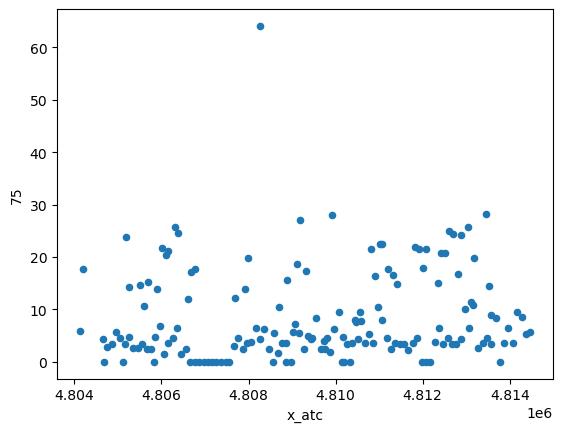

In [10]:
atl08['75'] = atl08.apply(lambda row : row["canopy_h_metrics"][icesat2.P['75']], axis = 1)
atl08.plot.scatter(x='x_atc', y='75')

#### Create Sample Waveform Plots

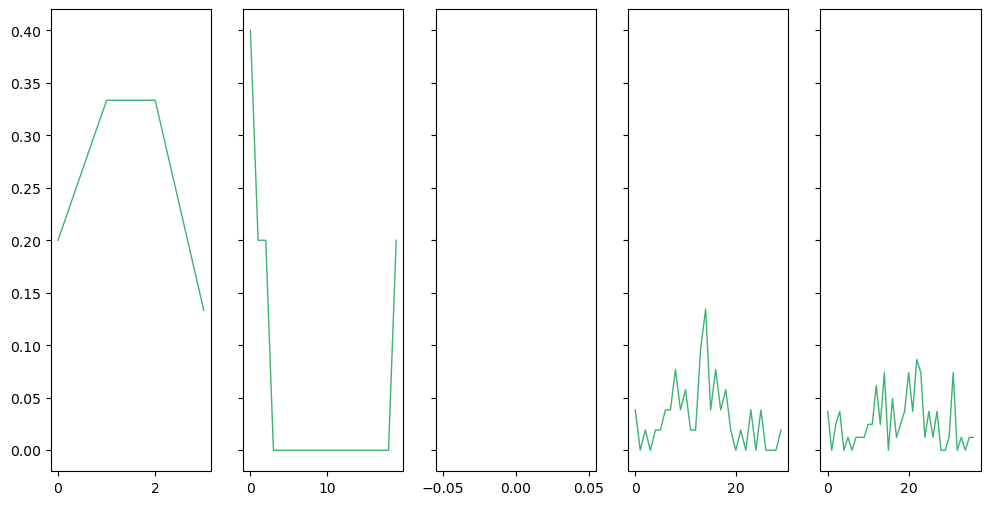

In [11]:
num_plots = 5
# waveform_index = [96, 97, 98, 100, 101]
waveform_index = [15, 25, 35, 45, 55]
fig,ax = plt.subplots(num=1, ncols=num_plots, sharey=True, figsize=(12, 6))
for x in range(num_plots):
    ax[x].plot([x for x in range(len(canopy_gt1l['waveform'][waveform_index[x]]))], canopy_gt1l['waveform'][waveform_index[x]], zorder=1, linewidth=1.0, color='mediumseagreen')
plt.show()

#### Make Atl06 Request
* Below we run an ATL06-SR processing request on the same source data using the same parameters.  Because the `keep_id` argument is set to true here and above when we made the ATL08 request, we can merge the resulting dataframes and have a single table of both elevation data using the customized ATL06-SR algorithm, and vegatation data using the PhoREAL algorithm.

In [12]:
atl06 = icesat2.atl06p(parms, keep_id=True)

request <AppServer.51294> retrieved 1 resources from CMR
Starting proxy for atl06 to process 1 resource(s) with 1 thread(s)
request <AppServer.51639> processing initialized on ATL03_20181126210453_09050102_006_02.h5 ...
request <AppServer.51639> processing of ATL03_20181126210453_09050102_006_02.h5 complete (182276/0/0)
request <AppServer.51639> processing complete (205/42/164/0)
Successfully completed processing resource [1 out of 1]: ATL03_20181126210453_09050102_006_02.h5


#### Merge Atl06 and Atl08 GeoDataFrames

In [13]:
gdf = geopandas.pd.merge(atl08, atl06, on='extent_id', how='left', suffixes=('.atl08','.atl06')).set_axis(atl08.index)
gdf

,snowcover,gt.atl08,canopy_openness,gnd_ph_count,rgt.atl08,x_atc.atl08,h_mean_canopy,h_canopy,h_max_canopy,ph_count,...,gt.atl06,w_surface_window_final,pflags,rgt.atl06,y_atc,h_mean,geometry.atl06,pce_mframe_cnt.atl06,solar_elevation,h_dif_ref.atl06
time,,,,,,,,,,,,,,,,,,,,,
2018-11-26 21:09:05.590024960,2,10,0.282533,0,905,4804119.5,5.501058,5.941040,5.941040,6,...,10,3.723408,2,905,1007.532471,1576.810698,POINT (-116.69177 43.16355),2.773317e+08,22.217695,-3.892578e+00
2018-11-26 21:09:05.600325120,2,10,11.117661,1,905,4804193.0,13.568094,48.431396,48.431396,36,...,10,9.887810,0,905,1007.464355,1573.761587,POINT (-116.69188 43.16445),2.773317e+08,22.217051,-3.892578e+00
2018-11-26 21:09:05.668974848,2,10,NaN,1,905,4804681.0,NaN,0.000000,0.000000,1,...,10,0.000000,2,905,NaN,NaN,POINT EMPTY,NaN,NaN,NaN
2018-11-26 21:09:05.730274816,2,10,NaN,1,905,4805116.5,NaN,0.000000,0.000000,1,...,10,0.000000,2,905,NaN,NaN,POINT EMPTY,NaN,NaN,NaN
2018-11-26 21:09:05.741675008,1,10,8.054248,0,905,4805197.0,22.436945,45.274536,45.274536,22,...,10,8.049331,0,905,1007.686584,1345.999099,POINT (-116.69306 43.17343),2.773317e+08,22.209208,3.402823e+38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26 21:09:07.330475008,1,20,1.469470,60,905,4814078.5,2.588119,6.997803,6.997803,91,...,20,9.139977,0,905,931.042786,1304.334985,POINT (-116.70256 43.25305),2.773318e+08,22.137156,5.055924e-01
2018-11-26 21:09:07.344025088,1,20,3.836523,14,905,4814174.5,5.592039,12.500610,13.663330,109,...,20,4.727525,4,905,931.253723,1322.809073,POINT (-116.70268 43.25394),2.773318e+08,22.136415,-1.174864e+00
2018-11-26 21:09:07.357975040,1,20,2.982843,8,905,4814273.5,6.160005,11.000000,12.374023,115,...,20,20.803690,0,905,931.265625,1333.731507,POINT (-116.70279 43.25484),2.773318e+08,22.135673,4.465581e+37
